# KCS

KCS es un formato de guardado de archivos binarios en forma de audio diseñado para almacenar información en cassettes de forma que sea fácil de codificar y decodificar con la tecnología de 1970. La descripción original del estandar se puede encontrar en el siguiente vínculo: [KCS](https://archive.org/details/byte-magazine-1976-02/page/n73/mode/1up?view=theater). 

Una implementación común usaría un circuito monoestable para detectar las frecuencias y un reloj de 300 baudios para cargar cada byte en memoria (es un tipo de comunicación serial). 

En esta implementación vamos a usar una transformada rápida de fourier para detectar las frecuencias y lógica de bits para interpretar el resultado como un byte completo. 

# Transformada rápida de fourier

La FTT (Fast fourier transform) es un algoritmo para computar la transformada discreta de fourier a partir de una lista de datos. La transformada de fourier es una función entre espacios de funciones que devuelve una representación de la función original en forma de sus frecuencias, intensidades y fases, esta transformada devuelve una función $\mathbb R \to \mathbb C$, en la que se guarda toda esta información, que se puede usar para reconstruir la onda original.

Vamos a usar esta transformada para detectar las frecuencias de la señal en este proyecto porque, aunque es más lenta que un circuito integrado, permite detectar más de una frecuencia al mismo tiempo y permite la extensión a paralelismo en trabajo futuro. 

La implementación de la transformada rápida que vamos a usar es la de numpy, pero para completar la definición, podemos hacer una implementación de la transformada discreta original. 

La transformada toma una secuencia de tamaño $N$, $(x_n)$ de números complejos y la transforma en 
$$
X_k = \sum_{n = 0}^{N - 1} x_n \exp(- \frac{i 2 \pi}{N} kn)
$$
para $k = 1, ..., N-1$

In [2]:
# Implementación de la transformada
# discreta de fourier
import numpy as np
from matplotlib import pyplot as plt
I = complex(0, 1)

def DFT(x):
    # toma una lista x de longitud N
    N = len(x)
    X = [
        sum([x[n] * np.exp(- I * 2 * np.pi/N * k * n)
            for n in range(0, N)
        ])
    for k in range(N)]
    return np.array(X)

In [3]:
#ahora probamos
import time

start = time.time()
x = np.sin(np.linspace(0, 1, 1000)*2*np.pi*20)
x2 = 2 * np.sin(np.linspace(0, 1, 1000)*2*np.pi*30)
x = x + x2
X = DFT(x)
end = time.time()
print(f"execution in  {end - start}s")

execution in  1.2469451427459717s


Es muy lento

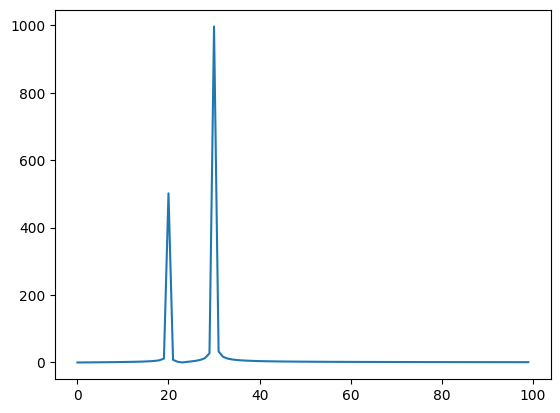

In [4]:
Y = np.absolute(X)
Y
plt.plot(Y[:100])
plt.savefig("DFTtest.pdf")

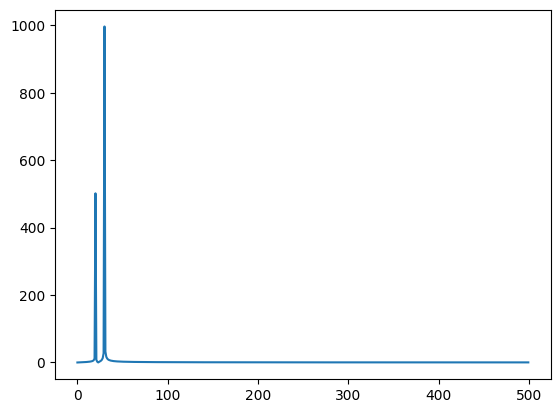

In [5]:
# el de numpy funciona exactamente igual, pero usa el algoritmo para computar rápido

X = np.fft.fft(x)
Y = np.absolute(X)
Y
plt.plot(Y[:len(Y)//2])

Hay que notar que la transformada devuelve las frecuencias en forma de $1/L$ donde $L$ es la longitud del intervalo en el que estamos haciendo la transformada. Como estábamos usando un invervalo de una unidad, las frecuencias se traducen correctamente, pero hay que ajustar eso en la implementación para diferentes tamaños de intervalo de sampleo.

Ahora implementemos una función que devuelva la frecuencia máxima en un intervalo:

In [5]:
def maxfreq(x, length):
    X = np.fft.fft(x)
    X = np.absolute(X)
    X = X[:len(X)//2]
    freq = np.argmax(X)
    return freq/length

In [6]:
maxfreq(x, 1)

30.0

Intentemos dividir un audio en pedazos pequeños y aplicar la función

In [7]:
from scipy.io import wavfile
samplerate, data = wavfile.read('test.wav')

In [7]:
from playsound import playsound
playsound("test.wav")

In [9]:
samples = 4410
time = samples/samplerate
dl = len(data)
duration = dl/samplerate
divs = dl // samples
for i in range(divs):
    d = data[i * samples : (i + 1) * samples]
    print(maxfreq(d, time))

440.0
440.0
440.0
440.0
440.0
880.0
880.0
880.0
880.0
880.0
440.0
440.0
440.0
440.0
440.0
440.0
440.0
440.0
440.0
440.0
880.0
880.0
880.0
880.0
880.0


Son justo las frecuencias que puse en audacity. 

Ahora metamos eso en una función:

In [10]:
def decompose(data, samples = 50): # uso 50 porque 50/samplerate < 1/600
    time = samples/samplerate
    dl = len(data)
    duration = dl/samplerate
    divs = dl // samples
    arr = np.zeros(divs)
    for i in range(divs):
        d = data[i * samples : (i + 1) * samples]
        arr[i] = maxfreq(d, time)
    return arr

44100


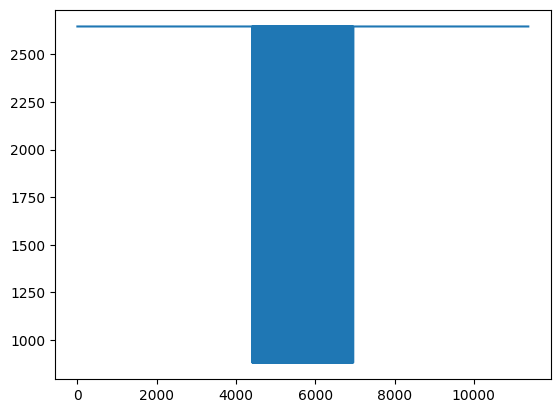

In [11]:
from scipy.io import wavfile
samplerate, data = wavfile.read('awa4000.wav')
print(samplerate)
X = decompose(data, samples = 50)
plt.plot(X)

Ahora implementemos el algoritmo para decodificar. El algoritmo tiene que funcionar de la siguiente forma:

Está en modo inactivo mientras siga recibiendo 2400hz. Si recibe frecuencias muy diferentes a las dos de la transmisión, se ignoran (cuando se lee un espacio de transición, pueden leerse armónicos mayores). 

Si lee una frecuencia de 1200hz, asume que se empezó la transmisión de un byte. Los siguientes 8 bits son los datos de la transmisión. 

Como la transmisión es de 300 baudios, a partir del primer tono de 1200, trasladamos 1/300 segundos y volvemos a leer 8 veces. 

Las ocho lecturas son nuestro byte organizado en little endian. Se debe revertir para obtener el byte original.

En el espacio discreto, 1/300 segundos será 

$$
\frac{1}{300} s \times \text{Sample Rate}\frac{samples}{s}
$$
Vamos a trabajar únicamente con 44100 samples/s así que la traslación sería de 147 samples. 

Implementemos la lectura del primer byte. Tendría que dar como resultado `0x65` o `101` porque la primera letra del archivo codificado es `e`

In [12]:
def ReadByte(data):
    samples = 50
    time = samples/44100
    dl = len(data)
    duration = dl/44100
    divs = dl // samples
    for i in range(divs):
        d = data[i * samples : (i + 1) * samples]
        fsamp = maxfreq(d, time)
        if abs(fsamp - 2400) < 500:
            #print("waiting")
            continue
        elif abs(fsamp - 1200) < 500:
            #print("reading")
            invbyte = int(0)
            for j in range(1,9):
                d = data[147 * j + i * samples: 147 * j + i * samples + 50]
                f = maxfreq(d, time)
                if abs(f - 2400) < 500:
                    invbyte += 1 * 2 ** (j - 1)
                elif abs(f - 1200) < 500:
                    invbyte += 0 * 2 ** (j - 1)
                else:
                    print("Read Error")
            return invbyte
        else: 
            print(f"unknown {fsamp}")
            continue

In [13]:
A = ReadByte(data)
A

101

Lee perfecto. Ahora, una vez leido el primer byte, vamos a movernos 1/300 segundos, cortar el array y volver a aplicar el algoritmo. Sabemos que después de completar el byte, hay al menos dos bits altos (por las especificaciones del formato), entonces si regresamos a modo espera, no debería haber errores de lectura.

In [14]:
def ReadBytes(data):
    DC = np.copy(data)[:-10]
    samples = 50
    time = samples/44100
    dl = len(DC)
    duration = dl/44100
    divs = dl // samples
    bytes = []
    while len(DC) > 1470:
        #print(len(DC))
        #print(bytes)
        for i in range(divs):
            d = DC[i * samples : (i + 1) * samples]
            fsamp = maxfreq(d, time)
            if abs(fsamp - 2400) < 500:
                #print("waiting")
                continue
            elif abs(fsamp - 1200) < 500:
                #print("reading")
                invbyte = int(0)
                for j in range(1,9):
                    d = DC[147 * j + i * samples: 147 * j + i * samples + 50]
                    if len(d) < 50: 
                        return bytearray(np.array(bytes, dtype = "uint8"))
                    f = maxfreq(d, time)
                    if abs(f - 2400) < 500:
                        invbyte += 1 * 2 ** (j - 1)
                    elif abs(f - 1200) < 500:
                        invbyte += 0 * 2 ** (j - 1)
                    else:
                        print("Read Error")
                bytes.append(invbyte)
                DC = DC[147 * 9 + i * samples:]
                break
            else: 
                #print(f"unknown {fsamp}")
                continue
    return bytes

Ahora escribamos los bytes a un archivo

In [15]:
result = ReadBytes(data)
for b in result:
    print(chr(b), end = '')

esto es una prueba

puse un espacio ahÃ­ para que tambiÃ©n haya nÃºmeros bajos


In [16]:
bytes(result)
with open("my_file.txt", "wb") as binary_file:
    binary_file.write(result)